In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
#from mlxtend.regressor import StackingCVRegressor
#from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
import os


# Any results you write to the current directory are saved as output.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Dimensión de los datos

In [3]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Data exploration

Quitar la columna ID

In [6]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

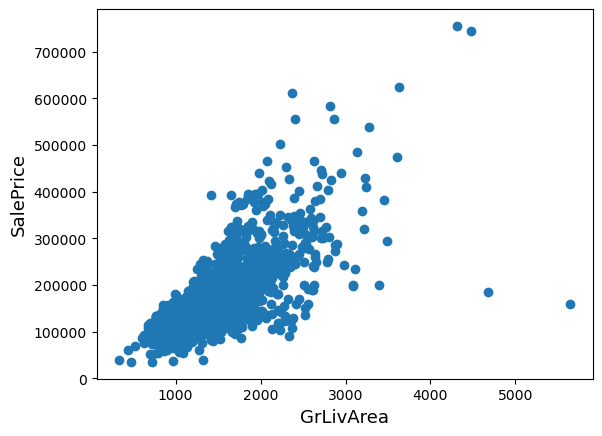

In [7]:
#Deleting outliers


#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [8]:
train = train[train.GrLivArea < 4500]

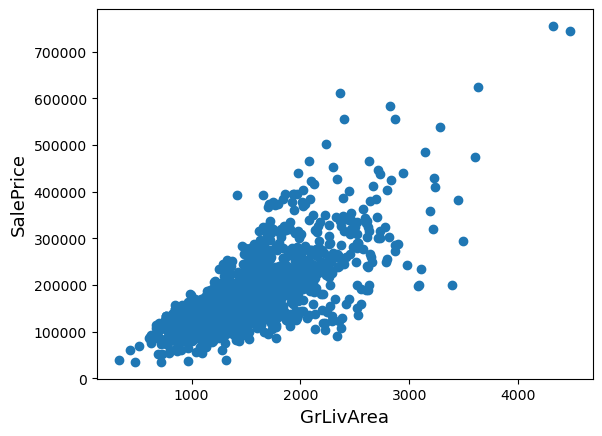

In [9]:
#Deleting outliers


#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

Se puede considerar quitar datos extremos, que puede que no aporten informacion al modelo y genere variacion inecesaria



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

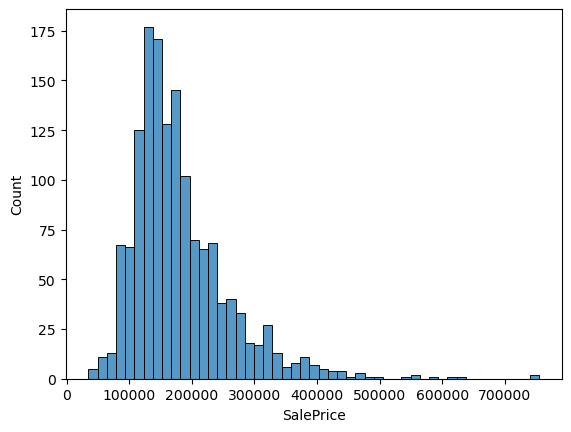

In [10]:
sns.histplot(train['SalePrice'])

### SalePrice es asimetrico por altos valores. Transformar con log1p 

In [16]:
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

Datos balanceados para el training

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

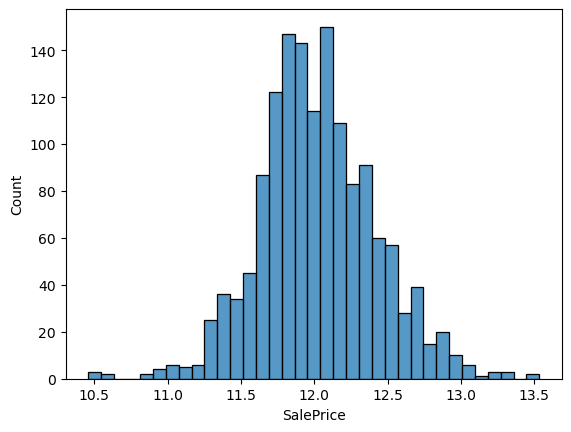

In [12]:
sns.histplot(train['SalePrice'])

Empezar a guardar variables X, Y separadas para evitar interferencias en la transformación y preprocesado.
Unir los datos de test al training, para que se lleve a cabo el mismo preprocesado

In [13]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
df = pd.concat([train_features, test_features]).reset_index(drop=True)

## Datos faltantes categoricos

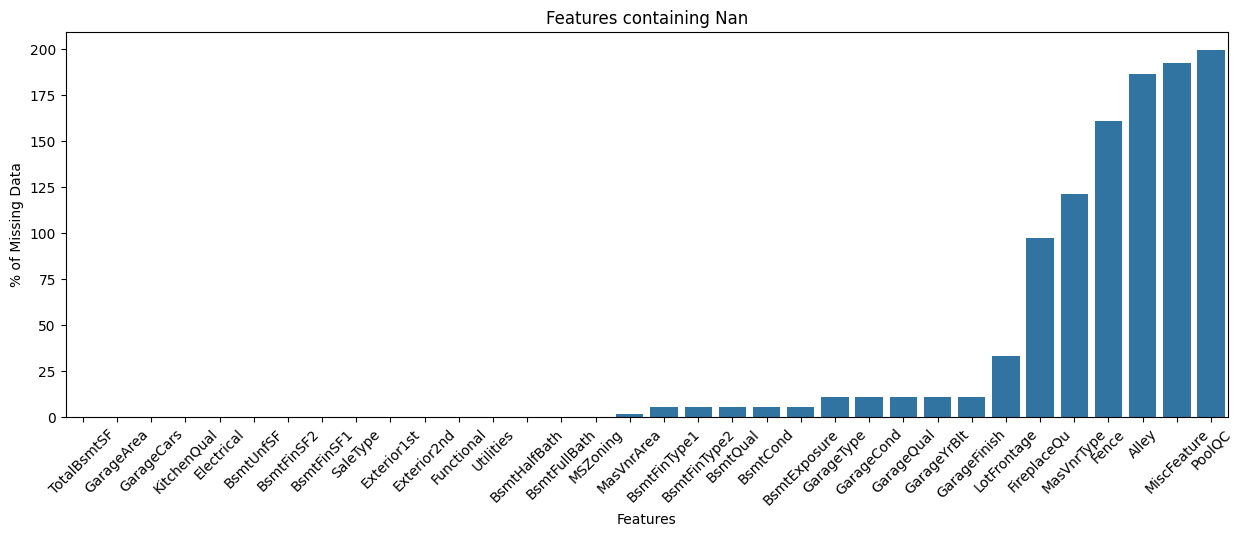

In [15]:
nan = pd.DataFrame(df.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

plt.figure(figsize = (15,5))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

In [16]:


# convertir variables numericas en categoricas, ya que no son continuas y aportan mas al modelo como datos categoricos
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)
df['OverallCond'] = df['OverallCond'].astype(str)



## A pesar de que los datos faltantes de esta sección se rellena con los datos mas convientes 
df['Functional'] = df['Functional'].fillna('Typ') # Segun la información de los datos : Assume typical unless deductions are warranted
df['Electrical'] = df['Electrical'].fillna("SBrkr") # Falta de informacion consideramos como el regular por lo tanto:Standard Circuit Breakers & Romex
df['KitchenQual'] = df['KitchenQual'].fillna("TA") #al dato faltante lo asumimos como cocina tipica 

#Se consideran los datos faltantes como ausencia de piscina
df["PoolQC"] = df["PoolQC"].fillna("None")



## En este caso como tiene diferentes niveles, es preferible dar un dato faltante segun la moda
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0]) 
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])


In [17]:
### En estos casos, donde no hay garaje se asume que el puntaje para los demas parametros realcionados a garaje sean cero o'None' 

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df[col] = df[col].fillna('None')

    
### Lo mismo con el sotano

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')


Como MSSubClass contiene MSZoning, se hace necesario hacer la imputacion de la moda con cada subgrupo de MSSubClassm

In [18]:
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

 ### Para el resto de datos se llena con None

In [19]:
objects = []
for i in df.columns:
    if df[i].dtype == object:
        objects.append(i)
df.update(df[objects].fillna('None'))
print(objects)


['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


## Datos faltantes numericos

In [20]:
# Dependiendo del barrio, se hace un subgrupo para rellenar los datos de LotFrontage de acuerdo a la media del subgrupo
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Para el resto de datos faltantes los asumimos como ceros
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in df.columns:
    if df[i].dtype in numeric_dtypes:
        numerics.append(i)
df.update(df[numerics].fillna(0))
numerics[1:10]

['LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF']

## Correlacion de SalePrice con las diferentes columnas

<Axes: >

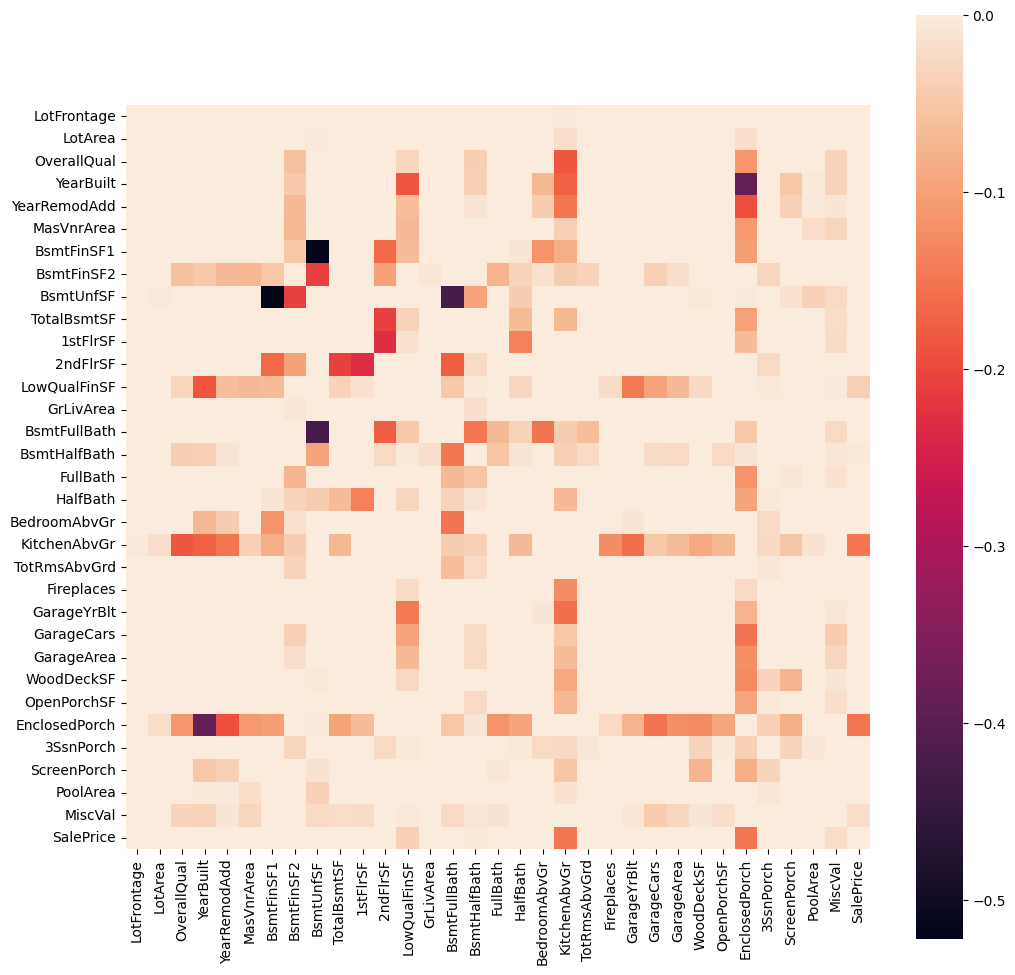

In [21]:
dfp=pd.concat([df[0:1458],train['SalePrice']], axis=1)
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(dfp.select_dtypes(include=['number']).corr(), vmax=0, square=True)
#https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

## Correlacion entre variables y 'SalePrice' top 10

<Axes: >

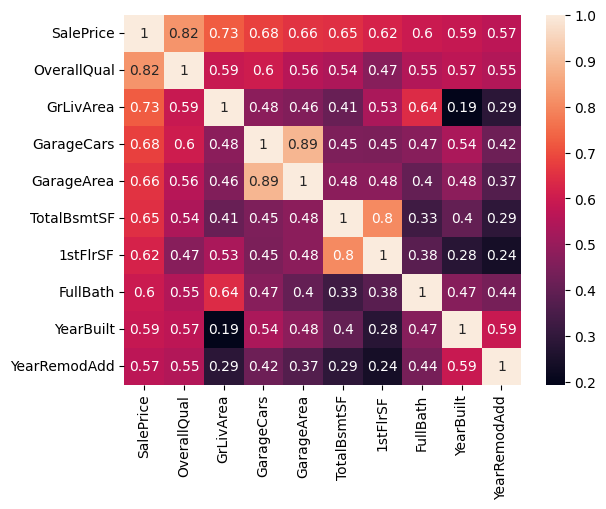

In [22]:
k = 10
cols = dfp.select_dtypes(include=['number']).corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(dfp[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, xticklabels=cols.values, yticklabels=cols.values)
#https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

In [23]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Observación de desbalanceo de datos

A partir de lo observado para el SalePrice, se revisa si existen muchos mas propiedades o columnas con distribución desbalanceados

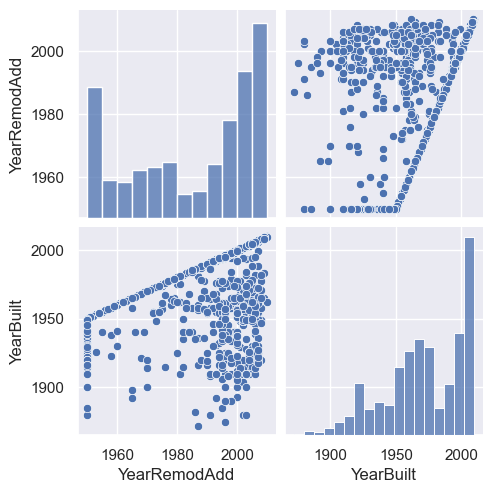

In [24]:
#scatterplot
sns.set_theme()
cols = ['YearRemodAdd', 'YearBuilt']
sns.pairplot(dfp[cols], height = 2.5, )
plt.show()
#https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

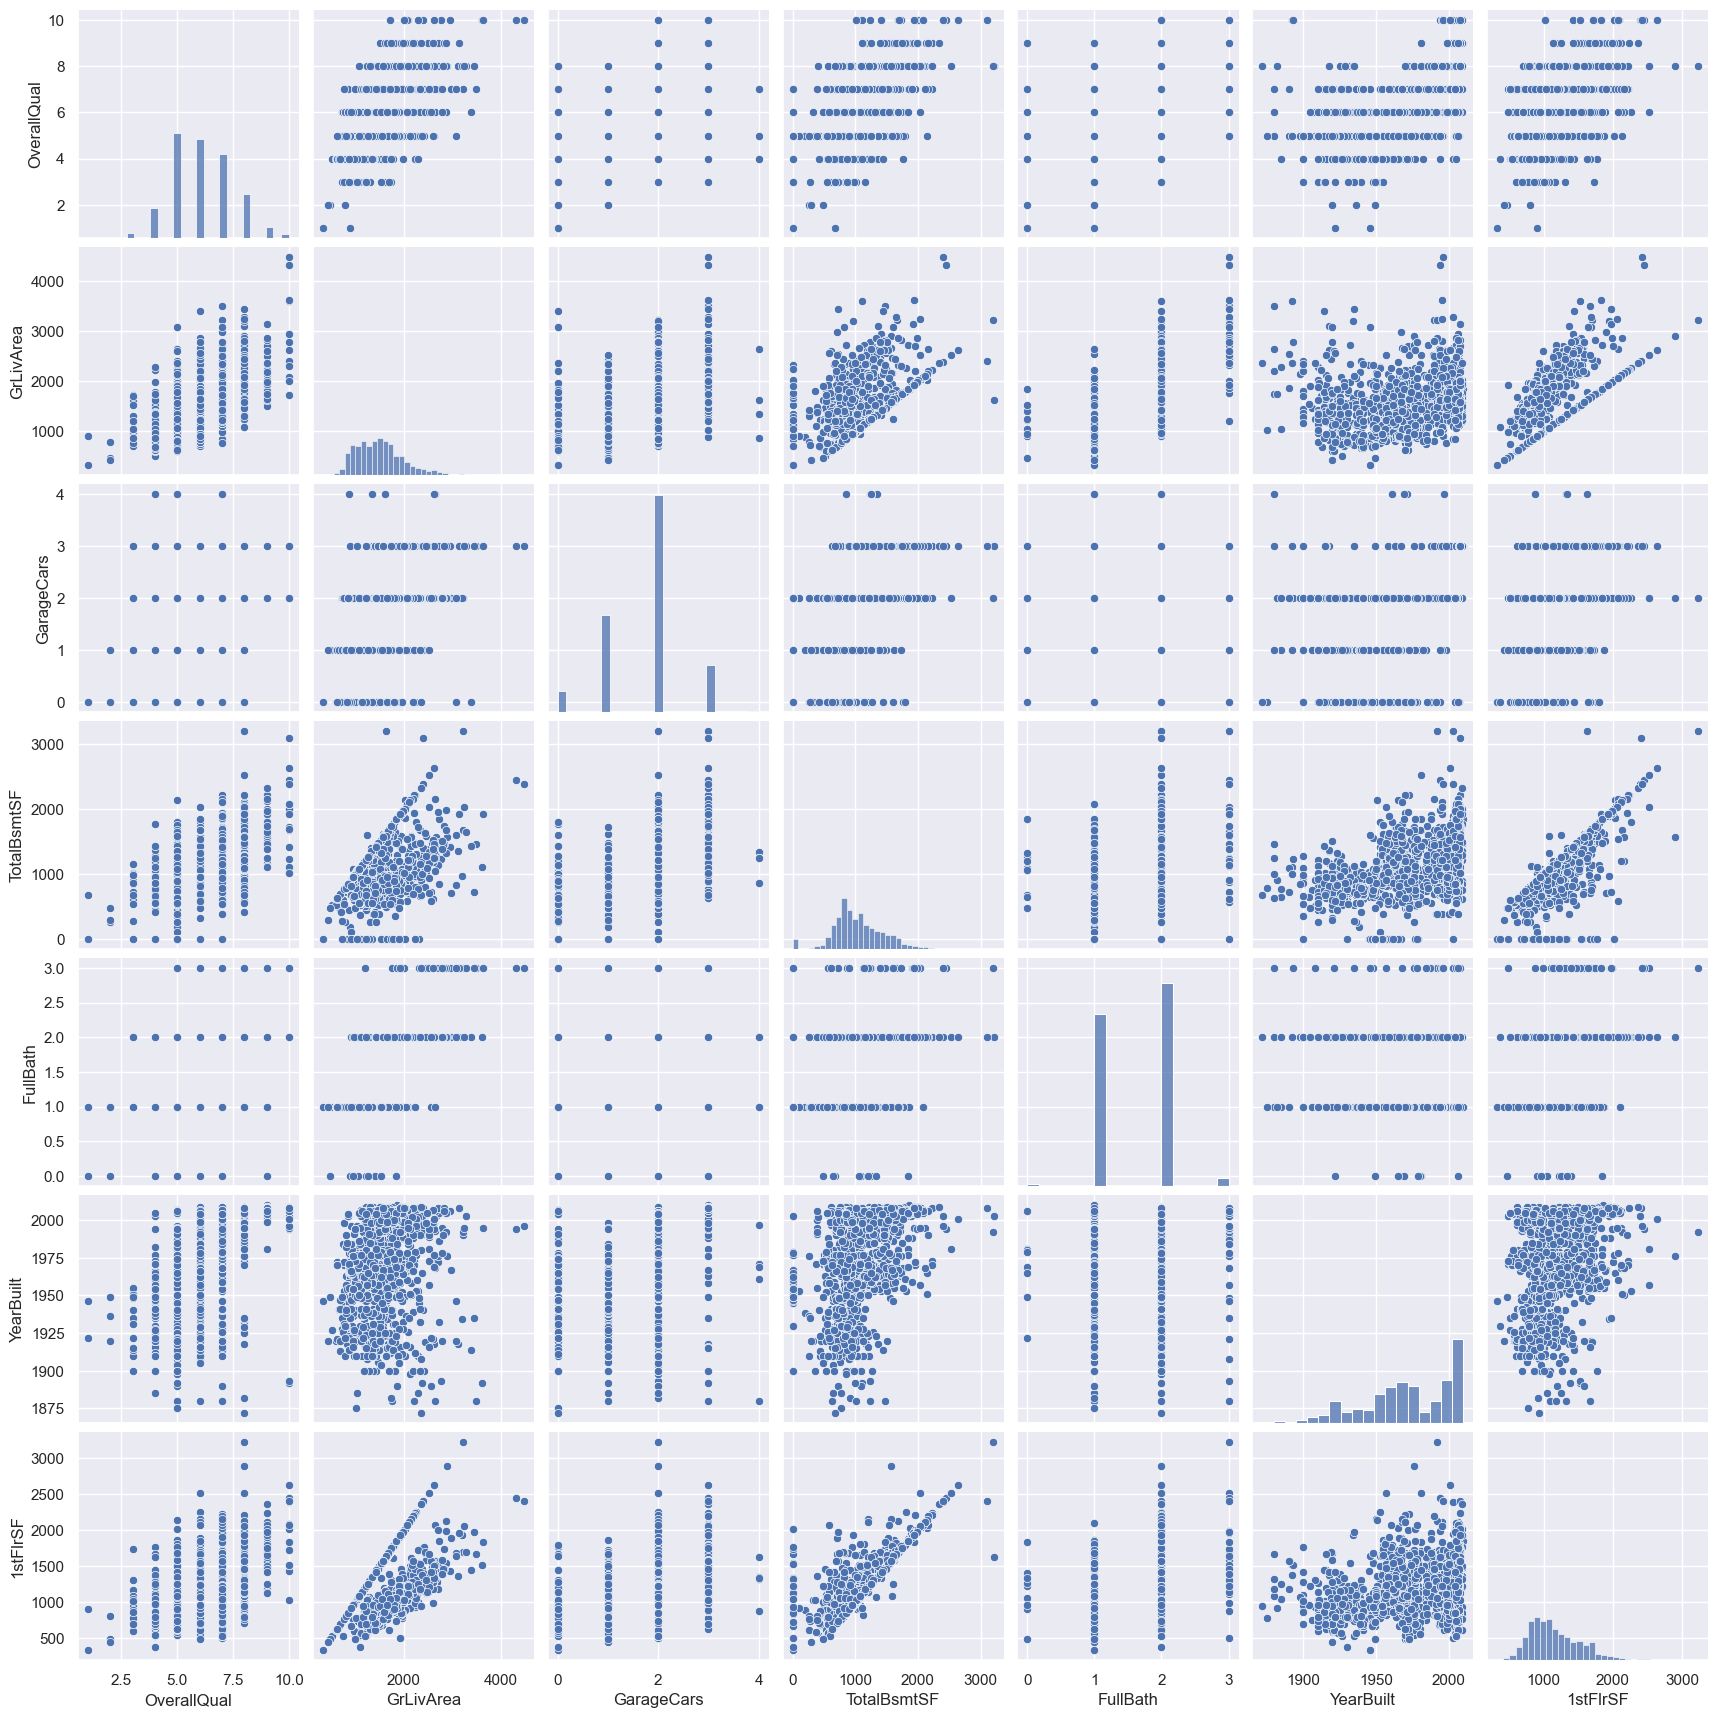

In [25]:
#scatterplot
sns.set_theme()
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', '1stFlrSF']
sns.pairplot(dfp[cols], height = 2.5, )
plt.show()
#https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

Por lo tanto se evalua que columnas poseen una alta asimetria mayor a 0.5 y se procede a convertir estos datos 
usando boxcos transformation

In [26]:
skew_df = pd.DataFrame(df.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(df[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

# #https://www.kaggle.com/code/gcdatkin/top-10-house-price-regression-competition-nb/notebook

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.103039,1.103039,True
1,LotArea,13.109495,13.109495,True
2,OverallQual,0.189591,0.189591,False
3,YearBuilt,-0.599194,0.599194,True
4,YearRemodAdd,-0.450134,0.450134,False
5,MasVnrArea,2.621719,2.621719,True
6,BsmtFinSF1,0.980645,0.980645,True
7,BsmtFinSF2,4.144503,4.144503,True
8,BsmtUnfSF,0.919688,0.919688,True
9,TotalBsmtSF,0.671751,0.671751,True


Transformacion log

In [27]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    df[column] = np.log1p(df[column])


## A partir de la matriz de correlación se puede empezar a pensar en como reducir las columnas y puedan resumir la gran cantidad de columnas que conducen a los mismo en la contrucción del modelo







In [28]:
# Las siguientes columnas se eliminan de acuerdo al estudio de los datos
#https://www.kaggle.com/code/devarshraval/top-2-feature-selection-ridge-regression


df['YrBltAndRemod']=df['YearBuilt']+df['YearRemodAdd']
df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                                 df['1stFlrSF'] + df['2ndFlrSF'])

df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

# df['Years_Since_Remod'] = df['YrSold'].astype(int) - df['YearRemodAdd'].astype(int)

# df['Age']=df['YrSold'].astype(int) - df['YearBuilt'].astype(int)

# df['Newness']=df['Age']*df['Years_Since_Remod']

# df['Total_Home_Quality'] = df['OverallQual'].astype(int) + df['OverallCond'].astype(int)

# df['OverallQual'].astype(str)

# df['TotalLot'] = df['LotFrontage'] + df['LotArea']
# df['sqft_feet_living']=df['TotalBsmtSF']+df['GrLivArea']

df = df.drop(['Utilities','LandSlope','Condition2','RoofStyle','RoofMatl','Exterior2nd','BsmtExposure',
'BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','Heating','LowQualFinSF',
'BedroomAbvGr', 'PoolQC','Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', '3SsnPorch'], axis=1)

# Convertimos datos categoricos para el modelo

Ordinales

In [29]:
enc = OrdinalEncoder()
ordinal_features = {'OverallQual' : ['1', '2', '3', '4','5','6','7', '8', '9', '10' ],
                    'OverallCond' : ['1', '2', '3', '4','5','6','7', '8', '9', '10'],
                    'ExterQual' : ['Po', 'Fa', 'TA','Gd', 'Ex'],
                    'ExterCond' : ['Po', 'Fa', 'TA','Gd', 'Ex'],
                    'BsmtQual' : ['None','Po', 'Fa', 'TA','Gd', 'Ex'],
                    'BsmtCond' : ['None','Po', 'Fa', 'TA','Gd', 'Ex'], 
                    #'BsmtExposure' : ['None','No', 'Mn', 'Av','Gd'],
                    #'BsmtFinType1' : ['None','Unf', 'LwQ', 'Rec','BLQ','ALQ', 'GLQ'],
                    #'BsmtFinType2' : ['None','Unf', 'LwQ', 'Rec','BLQ','ALQ', 'GLQ'],   
                    'HeatingQC' : ['Po', 'Fa', 'TA','Gd', 'Ex'],
                    'KitchenQual' : ['Po', 'Fa', 'TA','Gd', 'Ex'], 
                    'FireplaceQu' : ['None','Po', 'Fa', 'TA','Gd', 'Ex'],    
                    'GarageQual' : ['None','Po', 'Fa', 'TA','Gd', 'Ex'],
                    'GarageCond' : ['None','Po', 'Fa', 'TA','Gd', 'Ex'],
                    #'PoolQC' : ['None','Po', 'Fa', 'TA','Gd', 'Ex'],
                                    }


df_ordinal = df[ordinal_features.keys()]


enc = OrdinalEncoder(categories=[ordinal_features[col] for col in df_ordinal.columns])


df_ordinal_encoded = enc.fit_transform(df_ordinal)

df_ordinal_encoded = pd.DataFrame(df_ordinal_encoded, columns=df_ordinal.columns).astype(int)


df[df_ordinal.columns] = df_ordinal_encoded

Categoricos

In [30]:
df = pd.get_dummies(df).reset_index(drop=True)
df.shape

(2917, 220)

Revisamos si ayudo a mejorar la correlacion con el top 10

<Axes: >

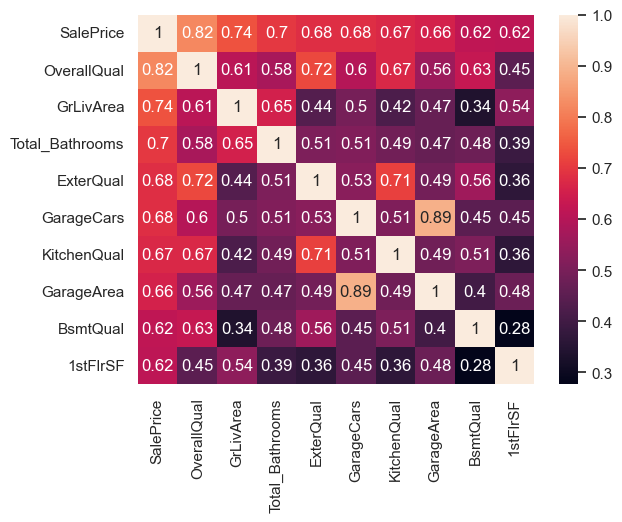

In [31]:
k = 10
dfp=pd.concat([df[0:1458],train['SalePrice']], axis=1)
cols = dfp.select_dtypes(include=['number']).corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(dfp[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, xticklabels=cols.values, yticklabels=cols.values)
#https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

Algunos de ellos entraron al top, por lo que es buen paso para la predicción posterior del modelo

## Ordenar dataframes para modelado

In [18]:
X = df.iloc[:len(y), :]
X_sub = df.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape


      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1453          60       RL         62.0     7917   Pave   NaN      Reg   
1454          20       RL         85.0    13175   Pave   NaN      Reg   
1455          70       RL         66.0     9042   Pave   NaN      Reg   
1456          20       RL         68.0     9717   Pave   NaN      Reg   
1457          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    Inside  ...  

In [33]:
X.shape, y.shape, X_sub.shape

((1458, 220), (1458,), (1459, 220))

# Pruebas de modelado 3 alternativas

## Pycaret

In [34]:
train_modificado=pd.concat([X,y], axis=1)

In [35]:
from pycaret.regression import *
s = setup(    
    data=train_modificado,
    target='SalePrice',
    session_id=123,
    use_gpu=False,
    n_jobs=None,

    train_size=0.99,)

,Description,Value
0,Session id,123
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1458, 221)"
4,Transformed data shape,"(1458, 221)"
5,Transformed train set shape,"(1443, 221)"
6,Transformed test set shape,"(15, 221)"
7,Numeric features,41
8,Preprocess,True
9,Imputation type,simple


In [111]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:42:16
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0766,0.0128,0.1124,0.9196,0.0088,0.0064,1.5820
br,Bayesian Ridge,0.0830,0.0135,0.1159,0.9146,0.0090,0.0069,0.2130
ridge,Ridge Regression,0.0831,0.0137,0.1168,0.9132,0.0091,0.0070,0.0280
lr,Linear Regression,0.0838,0.0144,0.1197,0.9089,0.0093,0.0070,0.1500
gbr,Gradient Boosting Regressor,0.0869,0.0155,0.1238,0.9024,0.0096,0.0073,0.6100
lightgbm,Light Gradient Boosting Machine,0.0875,0.0163,0.1268,0.8973,0.0099,0.0073,0.4980
xgboost,Extreme Gradient Boosting,0.0931,0.0182,0.1344,0.8851,0.0105,0.0078,0.2650
et,Extra Trees Regressor,0.0938,0.0183,0.1347,0.8848,0.0105,0.0078,1.6870
omp,Orthogonal Matching Pursuit,0.0985,0.0184,0.1352,0.8842,0.0105,0.0082,0.0260
rf,Random Forest Regressor,0.0953,0.0194,0.1382,0.8783,0.0108,0.0080,1.8310


In [40]:
cat = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0831,0.0138,0.1177,0.9144,0.0091,0.0069
1,0.0672,0.0108,0.1037,0.9266,0.0083,0.0057
2,0.0823,0.0157,0.1253,0.8906,0.0099,0.0069
3,0.0747,0.0098,0.0991,0.9317,0.0076,0.0062
4,0.0797,0.0150,0.1224,0.9047,0.0095,0.0067
5,0.0785,0.0174,0.1318,0.9097,0.0101,0.0066
6,0.0733,0.0101,0.1006,0.9325,0.0078,0.0061
7,0.0872,0.0152,0.1234,0.9230,0.0096,0.0073
8,0.0715,0.0109,0.1045,0.9262,0.0083,0.0060


In [37]:

lr = create_model('lr')
ridge = create_model('ridge')
br = create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0879,0.0159,0.1262,0.9014,0.0098,0.0074
1,0.0846,0.0131,0.1146,0.9104,0.0090,0.0071
2,0.0837,0.0164,0.1280,0.8858,0.0101,0.0070
3,0.0818,0.0119,0.1091,0.9172,0.0084,0.0068
4,0.0855,0.0160,0.1267,0.8979,0.0099,0.0072
5,0.0835,0.0170,0.1303,0.9117,0.0100,0.0070
6,0.0872,0.0138,0.1174,0.9080,0.0091,0.0073
7,0.0914,0.0161,0.1270,0.9184,0.0097,0.0076
8,0.0752,0.0115,0.1072,0.9224,0.0085,0.0063


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0811,0.0133,0.1151,0.9180,0.0089,0.0068
1,0.0824,0.0127,0.1129,0.9131,0.0089,0.0069
2,0.0856,0.0162,0.1273,0.8870,0.0101,0.0072
3,0.0829,0.0120,0.1095,0.9166,0.0084,0.0069
4,0.0853,0.0149,0.1219,0.9054,0.0095,0.0071
5,0.0838,0.0177,0.1329,0.9081,0.0102,0.0070
6,0.0865,0.0128,0.1130,0.9147,0.0087,0.0072
7,0.0937,0.0158,0.1255,0.9203,0.0096,0.0078
8,0.0731,0.0099,0.0994,0.9334,0.0078,0.0061


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0793,0.0125,0.1117,0.9228,0.0087,0.0066
1,0.0791,0.0119,0.1092,0.9186,0.0086,0.0067
2,0.0868,0.0168,0.1297,0.8828,0.0103,0.0073
3,0.0830,0.0115,0.1072,0.9201,0.0082,0.0069
4,0.0851,0.0144,0.1201,0.9082,0.0094,0.0071
5,0.0867,0.0183,0.1352,0.9049,0.0104,0.0072
6,0.0839,0.0118,0.1088,0.9209,0.0084,0.0070
7,0.0961,0.0162,0.1272,0.9181,0.0098,0.0080
8,0.0729,0.0103,0.1014,0.9306,0.0080,0.0061


In [168]:
catt = tune_model(cat, choose_better=True, n_iter=50)



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0895,0.0150,0.1224,0.9073,0.0095,0.0075
1,0.0730,0.0114,0.1068,0.9222,0.0085,0.0061
2,0.0898,0.0176,0.1326,0.8775,0.0105,0.0075
3,0.0761,0.0101,0.1003,0.9300,0.0077,0.0063
4,0.0772,0.0148,0.1218,0.9056,0.0095,0.0065
5,0.0873,0.0197,0.1402,0.8977,0.0107,0.0073
6,0.0758,0.0108,0.1041,0.9276,0.0081,0.0064
7,0.0897,0.0170,0.1305,0.9139,0.0101,0.0075
8,0.0774,0.0117,0.1083,0.9208,0.0086,0.0065


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [38]:
lrt = tune_model(lr, choose_better=True,n_iter=100)
ridget = tune_model(ridge, choose_better=True,n_iter=100)
brt = tune_model(br, choose_better=True,n_iter=100)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0790,0.0125,0.1117,0.9229,0.0086,0.0066
1,0.0796,0.0120,0.1098,0.9178,0.0087,0.0067
2,0.0866,0.0166,0.1290,0.8840,0.0102,0.0073
3,0.0831,0.0116,0.1078,0.9192,0.0083,0.0069
4,0.0852,0.0145,0.1203,0.9078,0.0094,0.0071
5,0.0858,0.0181,0.1344,0.9060,0.0103,0.0072
6,0.0843,0.0120,0.1093,0.9201,0.0084,0.0070
7,0.0950,0.0159,0.1260,0.9197,0.0097,0.0079
8,0.0725,0.0099,0.0997,0.9329,0.0078,0.0061


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0790,0.0125,0.1117,0.9228,0.0086,0.0066
1,0.0797,0.0121,0.1100,0.9175,0.0087,0.0067
2,0.0866,0.0166,0.1290,0.8841,0.0102,0.0073
3,0.0831,0.0116,0.1079,0.9190,0.0083,0.0069
4,0.0852,0.0145,0.1204,0.9077,0.0094,0.0071
5,0.0856,0.0180,0.1343,0.9062,0.0103,0.0072
6,0.0844,0.0120,0.1095,0.9199,0.0084,0.0070
7,0.0950,0.0159,0.1259,0.9198,0.0096,0.0079
8,0.0725,0.0100,0.0998,0.9328,0.0078,0.0061


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


## Stacking

In [115]:
stack1=stack_models([cat,lrt, ridget,brt], restack=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:00:52
Status,. . . . . . . . . . . . . . . . . .,Compiling Estimators
Estimator,. . . . . . . . . . . . . . . . . .,Stacking Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0806,0.0130,0.1140,0.9197,0.0088,0.0067
1,0.0742,0.0118,0.1084,0.9198,0.0086,0.0063
2,0.0841,0.0163,0.1276,0.8865,0.0101,0.0071
3,0.0787,0.0109,0.1045,0.9240,0.0080,0.0065
4,0.0810,0.0141,0.1187,0.9103,0.0093,0.0068
5,0.0798,0.0169,0.1299,0.9122,0.0100,0.0067
6,0.0841,0.0120,0.1097,0.9197,0.0085,0.0070
7,0.0935,0.0166,0.1290,0.9158,0.0099,0.0078
8,0.0670,0.0088,0.0937,0.9407,0.0074,0.0056


In [165]:
stack3=stack_models([cat,brt],  restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0822,0.0133,0.1154,0.9176,0.0089,0.0069
1,0.0666,0.0099,0.0994,0.9326,0.0079,0.0056
2,0.0869,0.0164,0.1282,0.8856,0.0101,0.0073
3,0.0741,0.0101,0.1007,0.9295,0.0077,0.0061
4,0.0804,0.0150,0.1225,0.9046,0.0096,0.0067
5,0.0748,0.0158,0.1257,0.9179,0.0096,0.0063
6,0.0779,0.0107,0.1034,0.9286,0.0080,0.0065
7,0.0905,0.0159,0.1260,0.9197,0.0097,0.0075
8,0.0711,0.0114,0.1069,0.9228,0.0084,0.0060


## Blending

In [116]:
blend=blend_models([cat,lrt, ridget,brt], choose_better=True, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0772,0.0123,0.1109,0.9239,0.0086,0.0065
1,0.0742,0.0111,0.1053,0.9244,0.0084,0.0063
2,0.0822,0.0157,0.1252,0.8909,0.0099,0.0069
3,0.0779,0.0103,0.1016,0.9282,0.0078,0.0065
4,0.0806,0.0141,0.1186,0.9104,0.0093,0.0068
5,0.0796,0.0167,0.1292,0.9132,0.0099,0.0067
6,0.0790,0.0108,0.1041,0.9277,0.0080,0.0066
7,0.0891,0.0147,0.1211,0.9258,0.0093,0.0074
8,0.0694,0.0096,0.0982,0.9349,0.0077,0.0058


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [141]:
blend1=blend_models([cat, ridget,brt],  optimize='RMSE')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:14:28
Status,. . . . . . . . . . . . . . . . . .,Compiling Estimators
Estimator,. . . . . . . . . . . . . . . . . .,Voting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0767,0.0119,0.1093,0.9262,0.0085,0.0064
1,0.0716,0.0107,0.1036,0.9268,0.0082,0.0060
2,0.0824,0.0157,0.1252,0.8908,0.0099,0.0069
3,0.0774,0.0102,0.1010,0.9290,0.0077,0.0064
4,0.0801,0.0138,0.1176,0.9120,0.0092,0.0067
5,0.0794,0.0170,0.1305,0.9114,0.0100,0.0066
6,0.0779,0.0104,0.1022,0.9302,0.0079,0.0065
7,0.0896,0.0148,0.1215,0.9253,0.0093,0.0075
8,0.0688,0.0096,0.0978,0.9355,0.0077,0.0058


In [42]:
blend3=blend_models([cat, brt],  optimize='RMSE')

In [174]:
blend4=blend_models([lrt, ridget],  optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0823,0.0136,0.1164,0.9161,0.0090,0.0069
1,0.0814,0.0124,0.1113,0.9154,0.0088,0.0069
2,0.0848,0.0164,0.1279,0.8861,0.0101,0.0071
3,0.0821,0.0115,0.1071,0.9202,0.0082,0.0068
4,0.0844,0.0149,0.1222,0.9050,0.0096,0.0071
5,0.0838,0.0172,0.1312,0.9105,0.0101,0.0070
6,0.0845,0.0124,0.1114,0.9170,0.0086,0.0071
7,0.0919,0.0155,0.1247,0.9214,0.0096,0.0076
8,0.0730,0.0102,0.1010,0.9311,0.0080,0.0061


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [43]:

final_best = s.finalize_model(blend3)

In [44]:
pred=s.predict_model(final_best, X_sub)

In [45]:
pred['SalePrice'] = np.expm1(pred.prediction_label)

In [49]:
submission = pd.read_csv("sample_submission.csv")

In [50]:
submission.iloc[:,1]=pred['SalePrice']

In [51]:
submission 

,Id,SalePrice
0,1461,126563.431049
1,1462,159009.756692
2,1463,180147.519369
3,1464,190528.001028
4,1465,194343.286322
...,...,...
1454,2915,80961.060869
1455,2916,78491.552291
1456,2917,161419.302618
1457,2918,115883.582616


In [52]:
submission.to_csv('submission_final.csv', index=False)

* blend 0.12685
* blend1 0.12527
* blend3 0.12478
* stack2 0.12676
* stack1 0.13053

## XGBOOST

In [84]:
param_grid = {
    'xgbregressor__learning_rate' : [0.06],
    'xgbregressor__n_estimators' : [590],
    'xgbregressor__max_depth': [3],
    'xgbregressor__colsample_bytree' : [0.4],
    'xgbregressor__subsample': [0.88],
}

In [85]:
pipe = make_pipeline(XGBRegressor())

model = GridSearchCV(pipe, param_grid, cv=8,
                     scoring='neg_mean_absolute_error',
                     n_jobs=4, verbose=1)

model.fit(X, y)

print(f"Best parameters: {model.best_params_}")

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Best parameters: {'xgbregressor__colsample_bytree': 0.4, 'xgbregressor__learning_rate': 0.06, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 590, 'xgbregressor__subsample': 0.88}


In [86]:
y_pred = model.best_estimator_.predict(X_sub)

In [87]:
pred = np.expm1(y_pred)

In [53]:
submission = pd.read_csv("sample_submission.csv")

In [89]:
submission.iloc[:,1]=pred

In [90]:
submission

,Id,SalePrice
0,1461,134104.515625
1,1462,163679.796875
2,1463,187556.531250
3,1464,192290.203125
4,1465,187042.093750
...,...,...
1454,2915,81834.515625
1455,2916,76872.539062
1456,2917,158618.140625
1457,2918,112737.242188


In [91]:
submission.to_csv('submissionAl.csv', index=False)

0.13144

# Modelado kaggle

* K-Folds cross-validator

* evaluar el modelo en kfolds (con mezcla).


In [92]:
# https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb


kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [93]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [94]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=10000, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=10000, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [95]:
gbr = GradientBoostingRegressor( learning_rate=0.05, max_depth=4, max_features='sqrt', random_state =42)                             

In [96]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [97]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

## Stacking 


### Estrategia para evitar overfitting en el training data


In [98]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Comparación de modelos

In [99]:


score = cv_rmse(ridge , X)
print("ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(lasso , X)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

ridge: 0.1141 (0.0136)
 2024-05-29 08:37:58.290476


c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024581624764827836, tolerance: 0.018838953935048683
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.050955503140235336, tolerance: 0.01866763525076451
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1727981201519473, tolerance: 0.01866763525076451
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\pyc

LASSO: 0.1136 (0.0139)
 2024-05-29 08:38:03.202564


c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024581624497109544, tolerance: 0.018838953935048683
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021229833334231785, tolerance: 0.01859128884619197
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036303528662127604, tolerance: 0.019496413464067223
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\

elastic net: 0.1137 (0.0139)
 2024-05-29 08:38:21.902131
SVR: 0.1122 (0.0174)
 2024-05-29 08:38:23.294787
lightgbm: 0.1158 (0.0146)
 2024-05-29 08:39:02.984102
gbr: 0.1260 (0.0128)
 2024-05-29 08:39:03.775825


c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\xgboost\core.py:160: UserWarning: [08:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\xgboost\core.py:160: UserWarning: [08:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\xgboost\core.py:160: UserWarning: [08:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now de

xgboost: 0.1124 (0.0122)
 2024-05-29 08:39:40.726122


In [100]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen


c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018782135748137918, tolerance: 0.017406490495489847
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02035620069070987, tolerance: 0.017202716899185476
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04202049252206308, tolerance: 0.01738705713660106
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\usuario\anaconda3\envs\py

elasticnet
Lasso


c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06656326525428469, tolerance: 0.021315003834910043
  model = cd_fast.enet_coordinate_descent_gram(


Ridge
Svr
GradientBoosting
xgboost


c:\Users\usuario\anaconda3\envs\pycaret\Lib\site-packages\xgboost\core.py:160: UserWarning: [08:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


lightgbm


# Mezcla de modelos
* la participación de cada modelo para mejorar

In [101]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [102]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.06941448961021188


In [103]:
print('Predict submission')
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(X_sub)))

Predict submission


# Submission

In [104]:
submission.head()

,Id,SalePrice
0,1461,125640.725498
1,1462,160296.566426
2,1463,184491.967672
3,1464,194758.182151
4,1465,192600.744180


In [105]:
submission.to_csv('submissionn.csv', index=False)

0.12329